# *Transformer* Encoder

In [2]:
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import random
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        return torch.from_numpy(np.array(self.X[ix])).float(), torch.from_numpy(np.array(self.y[ix])).long()

class DataModule(pl.LightningDataModule):

    def __init__(self, dt_train, dt_test, batch_size: int = 64, Dataset = Dataset):
        super().__init__()
        self.batch_size = batch_size
        self.Dataset = Dataset
        self.dt_train = dt_train
        self.dt_test = dt_test

    def setup(self, stage=None):
        X_train, y_train = zip(*[self.dt_train[i] for i in range(len(self.dt_train))])
        X_train = torch.stack(X_train)
        y_train = torch.tensor(y_train)
        X_test, y_test = zip(*[self.dt_test[i] for i in range(len(self.dt_test))])
        X_test = torch.stack(X_test)
        y_test = torch.tensor(y_test)
        X_train = X_train.reshape(-1, 3*64*64)
        X_test = X_test.reshape(-1, 3*64*64)
        self.train_ds = self.Dataset(X_train, y_train)
        self.val_ds = self.Dataset(X_test, y_test)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

In [12]:
# Ruta donde se almacenarán los datos
root = 'datasets/Fast_Food/'

# Transformaciones de datos
transform = transforms.Compose([
        # transformar a escala de grises
        #transforms.Grayscale(num_output_channels=1),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
])

# Instanciar el DataModule
train_dataset = ImageFolder(root=root+"Train", transform=transform)
test_dataset = ImageFolder(root=root+"Valid", transform=transform)
print(f"Train: {len(train_dataset)}")
print(f"Test: {len(test_dataset)}")

# clases del dataset fer2013
classes = ('Baked Potato', 'Burger', 'Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Pizza', 'Sandwich', 'Taco', 'Taquito')

Train: 15000
Test: 3500


In [13]:
dm = DataModule(train_dataset, test_dataset, batch_size=64, Dataset = Dataset)
dm.setup()
imgs, labels = next(iter(dm.train_dataloader()))
imgs.shape, labels.shape

(torch.Size([64, 12288]), torch.Size([64]))

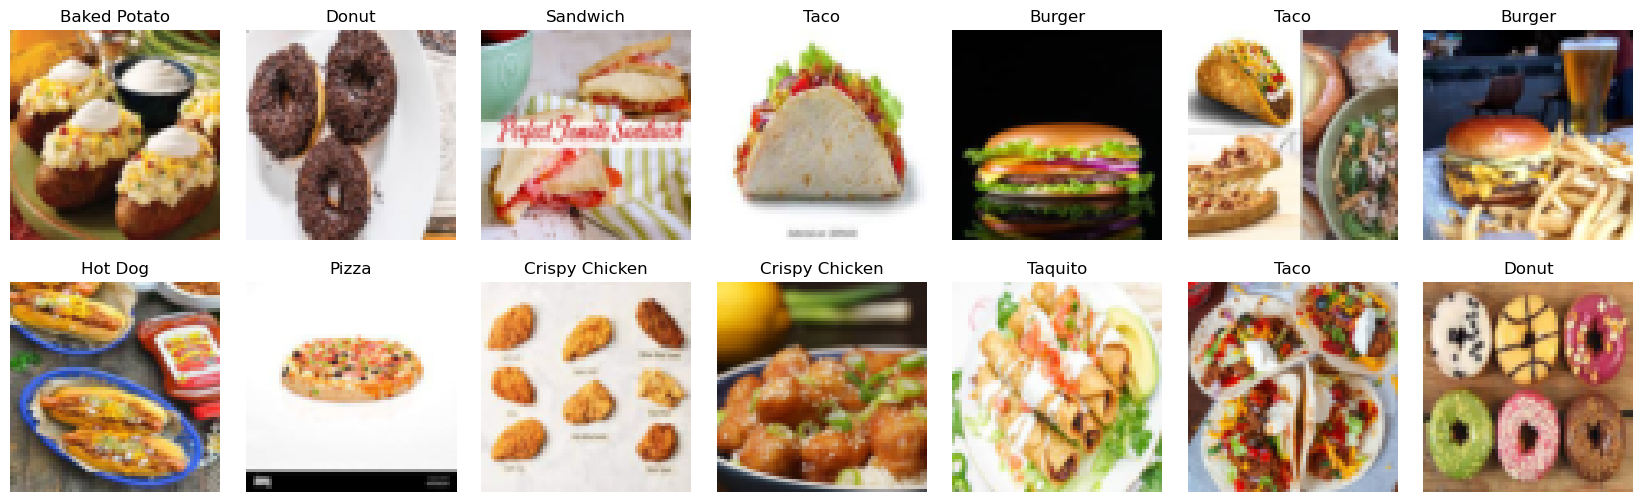

In [14]:
r, c = 2, 7
plt.figure(figsize=(c * 3, r * 3))
for row in range(r):
    for col in range(c):
        index = c * row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(train_dataset) - 1)
        img, label = train_dataset[ix]
        plt.imshow(img.reshape(3, 64, 64).permute(1, 2, 0).numpy())
        plt.axis("off")
        plt.title(classes[label])
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

In [15]:
class MLP(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(3*64*64, 3*64*64),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(3*64*64, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.mlp(x)

    def predict(self, x):
        with torch.no_grad():
          y_hat = self(x)
          return torch.argmax(y_hat, axis=1)
        
    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('loss', loss)
        self.log('acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0003)
        return optimizer

In [16]:
mlp = MLP()
outuput = mlp(torch.randn(32, 3*64*64))
outuput.shape

torch.Size([32, 10])

In [17]:
mlp = MLP()
trainer = pl.Trainer(max_epochs=5, logger=None)
trainer.fit(mlp, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\israe\anaconda3\envs\cuda_user\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 151 M 
------------------------------------
151 M     Trainable params
0         Non-trainable params
151 M     Total params
604.520   Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\israe\anaconda3\envs\cuda_user\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


c:\Users\israe\anaconda3\envs\cuda_user\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 4: 100%|██████████| 235/235 [00:13<00:00, 17.54it/s, v_num=19, acc=0.417, val_loss=1.990, val_acc=0.263] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 235/235 [00:43<00:00,  5.45it/s, v_num=19, acc=0.417, val_loss=1.990, val_acc=0.263]


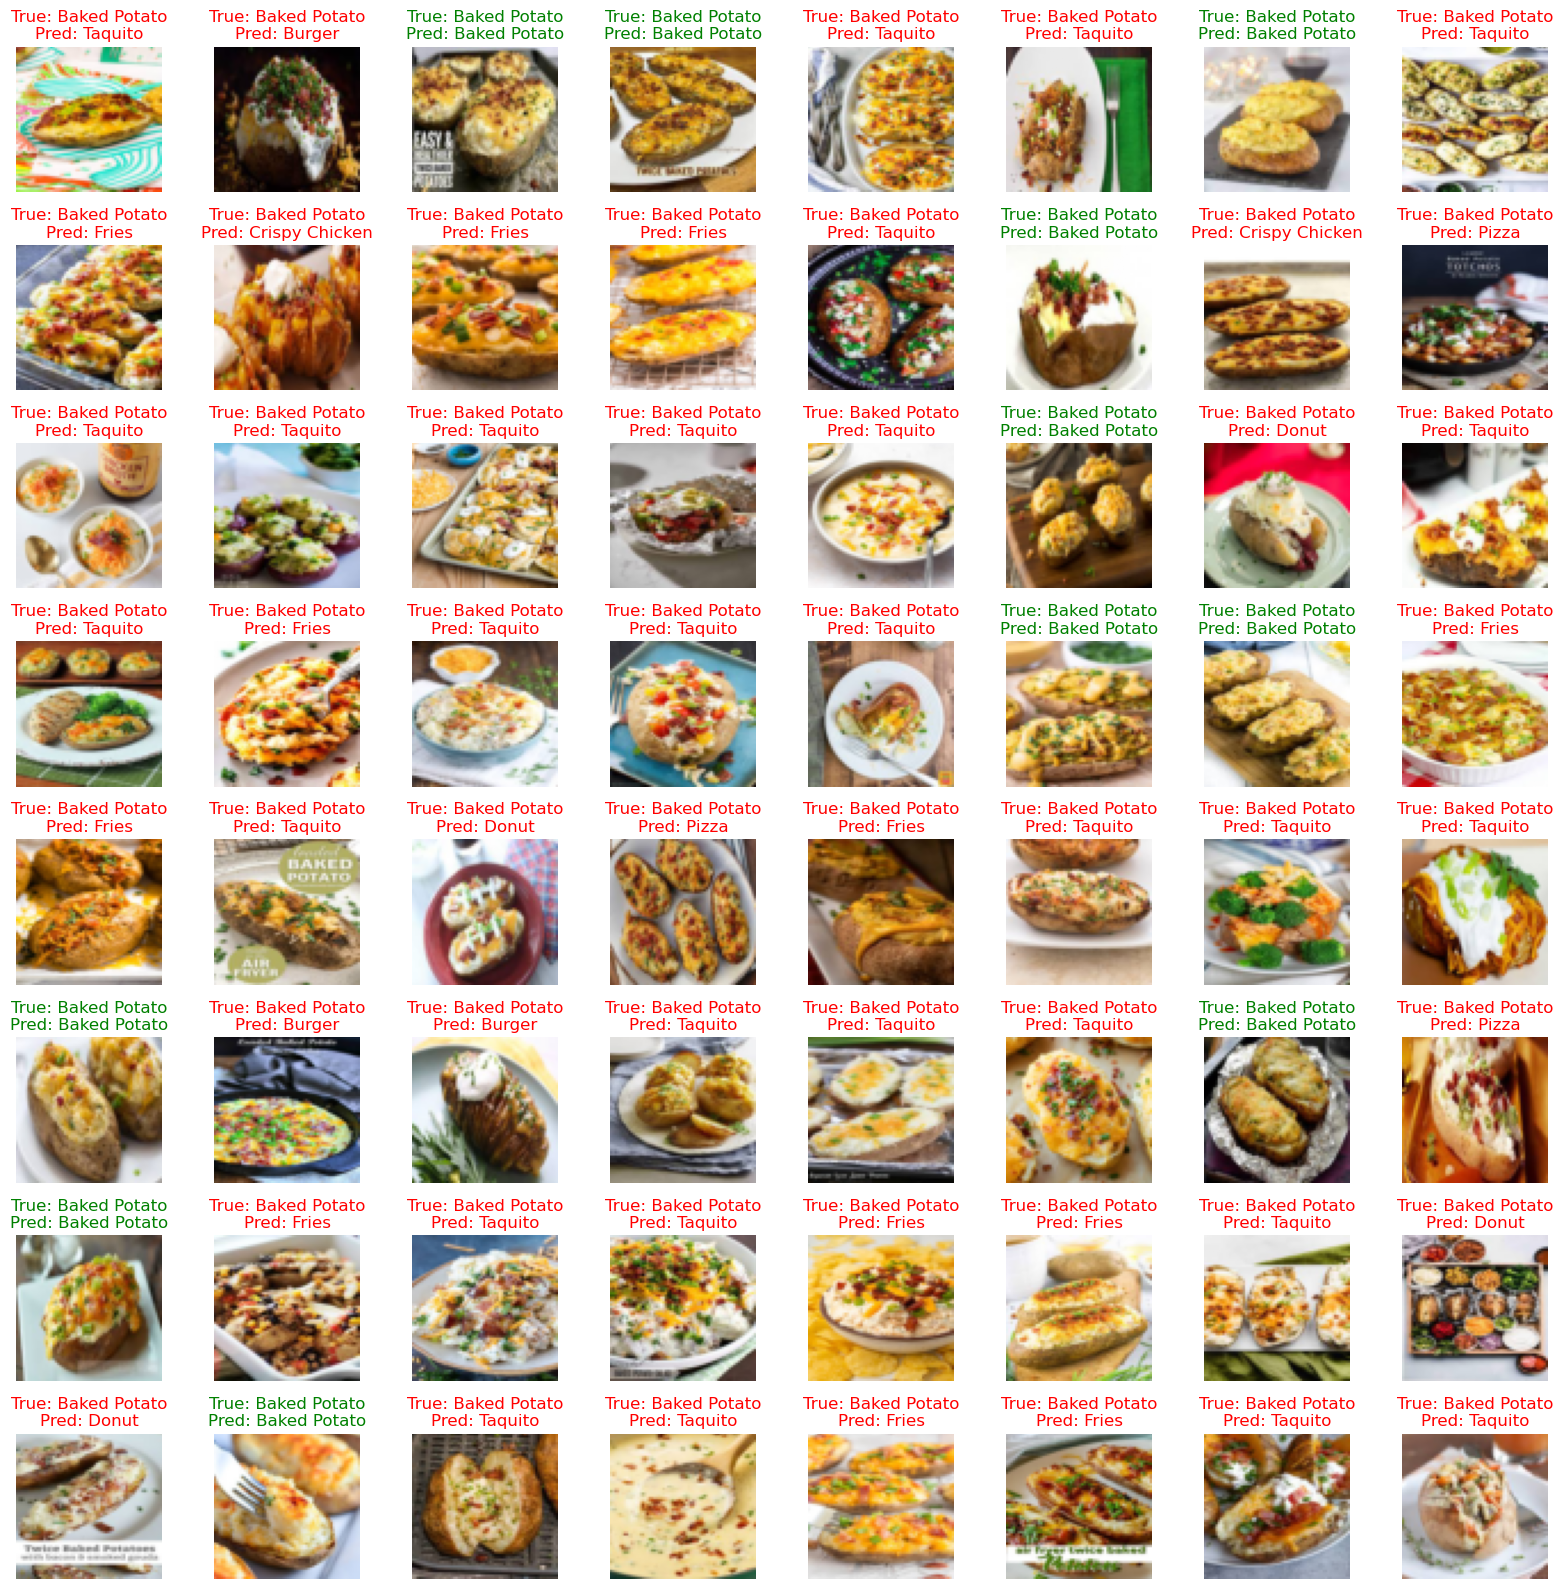

In [18]:
imgs, labels = next(iter(dm.val_dataloader()))
preds = mlp.predict(imgs)

r, c = 8, 8
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.reshape(3,64,64).permute(1, 2, 0).numpy())
        color = "green" if label == preds[ix] else "red"
        ax.set_title(f"True: {classes[label]}\nPred: {classes[preds[ix]]}", color=color)
plt.tight_layout()
plt.show()

In [23]:
class AttnDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, patch_size=(8, 8)):
        self.X = X 
        self.y = y 
        self.patch_size = patch_size

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        image = self.X[ix].clone().detach().float().view(3, 64, 64)  # Canal x Altura x Ancho (3 x 64 x 64)
        h, w = self.patch_size
        patches = image.unfold(1, h, h).unfold(2, w, w)  # 3 x 8 x 8 x 8 x 8
        patches = patches.contiguous().view(-1, 3, h*w)  # 108 x 64 (3 canales x tamaño del parche)

        return patches, self.y[ix].clone().detach().long()

In [26]:
attn_dm = DataModule(train_dataset, test_dataset, batch_size=32, Dataset = AttnDataset)
attn_dm.setup()

In [27]:
imgs, labels = next(iter(attn_dm.train_dataloader()))
imgs.shape, labels.shape

(torch.Size([32, 64, 3, 64]), torch.Size([32]))

In [ ]:
# basado en: https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
import math

class MultiHeadAttention(torch.nn.Module):

    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.n_heads = n_heads 
        
        # key, query, value projections
        self.key = torch.nn.Linear(n_embd, n_embd*n_heads)
        self.query = torch.nn.Linear(n_embd, n_embd*n_heads)
        self.value = torch.nn.Linear(n_embd, n_embd*n_heads)
        
        # output projection
        self.proj = torch.nn.Linear(n_embd*n_heads, n_embd)

    def forward(self, x):
        B, L, F = x.size()
        
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        q = self.query(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        v = self.value(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        
        # attention (B, nh, L, F) x (B, nh, F, L) -> (B, nh, L, L) 
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v # (B, nh, L, L) x (B, nh, L, F) -> (B, nh, L, F)
        y = y.transpose(1, 2).contiguous().view(B, L, F*self.n_heads) # re-assemble all head outputs side by side
        
        return self.proj(y)
    
class TransformerBlock(torch.nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.ln1 = torch.nn.LayerNorm(n_embd)
        self.ln2 = torch.nn.LayerNorm(n_embd)
        self.attn = MultiHeadAttention(n_embd, n_heads)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(n_embd, 4 * n_embd),
            torch.nn.ReLU(),
            torch.nn.Linear(4 * n_embd, n_embd),
        )
        
    def forward(self, x):
        x = self.ln1(x + self.attn(x))
        x = self.ln2(x + self.mlp(x))
        return x
    
class Model(MLP):

    def __init__(self, n_input=8*8, n_embd=8*8, seq_len=8*8, n_heads=16*16, n_layers=1):
        super().__init__()
        self.mlp = None
        self.pos_emb = torch.nn.Parameter(torch.zeros(1, seq_len, n_embd))
        self.inp_emb = torch.nn.Linear(n_input, n_embd)
        self.tranformer = torch.nn.Sequential(*[TransformerBlock(n_embd, n_heads) for _ in range(n_layers)])
        self.fc = torch.nn.Linear(n_embd*seq_len, 7)

    def forward(self, x):
        # embedding
        e = self.inp_emb(x) + self.pos_emb
        # transformer blocks
        x = self.tranformer(e)
        # classifier
        y = self.fc(x.view(x.size(0), -1))
        return y

In [ ]:
model = Model(n_layers=3)
trainer = pl.Trainer(max_epochs=50, logger=None)
trainer.fit(model, attn_dm)

In [ ]:
attn_imgs, attn_labels = next(iter(attn_dm.val_dataloader()))
preds = model.predict(attn_imgs)

ix = random.randint(0, attn_dm.batch_size)
fig = plt.figure(figsize=(5,5))
for i in range(6):
    for j in range(6):
        ax = plt.subplot(6, 6, i*6 + j + 1)
        ax.imshow(attn_imgs[ix,i*6 + j].view(8, 8), cmap="gray")
        ax.axis('off')
fig.suptitle(f'{classes[attn_labels[ix]]} / {classes[preds[ix].item()]}', color="green" if attn_labels[ix] == preds[ix].item() else "red")
plt.tight_layout()
plt.show()